# Flatiron School for Data Science - Capstone Project
* Student name: John J. Cho
* Student pace: full time online
* Instructor name: Rafael Carrasco
* Blog post URL: 

## Exploring Effects of Shelter-In-Place (SIP) Due to COVID-19 - Nintendo Switch Resale Pricing on eBay - Spring 2020

In [1]:
# Importing libraries, files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import datetime as dt

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_csv('df.csv')
df_lite = pd.read_csv('df_lite.csv')

#### Due to the frequency of missing information/pages for older listings, we will drop everything before Feb 13.

In [13]:
# Convert date column to datetime object in order to perform comparisons
df.Date = pd.to_datetime(df.Date)
df = df[df.Date > '2020-02-13']
df.set_index('Date').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13926 entries, 2020-05-13 20:54:00 to 2020-02-13 00:10:00
Data columns (total 9 columns):
Title        13926 non-null object
Price        13926 non-null float64
Shipping     13926 non-null float64
Condition    13926 non-null object
Link         13926 non-null object
Location     13926 non-null object
Seller       13926 non-null object
Feedback     13926 non-null float64
FBScore      13926 non-null float64
dtypes: float64(4), object(5)
memory usage: 1.1+ MB


# Exploratory Data Analysis (EDA)
### Let's take an initial peek at a plot of our closing prices over time.

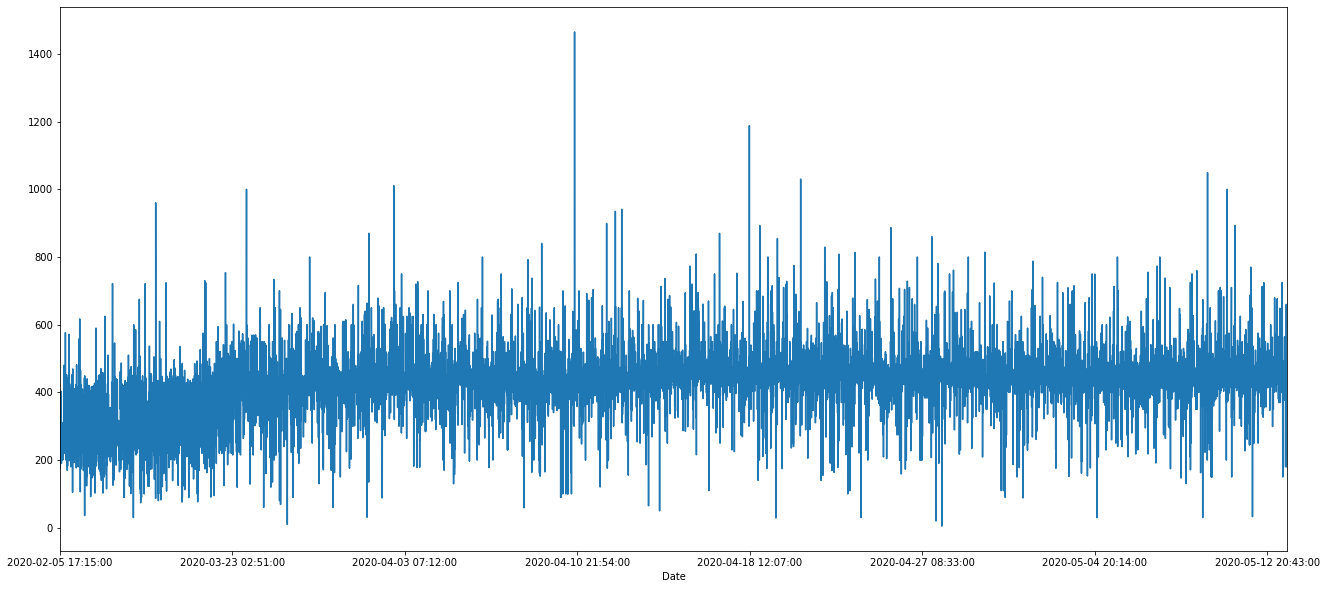

In [9]:
# Update Price to include Shipping so it correctly reflects total cost to buyer
df.Price = df.Price + df.Shipping
df.set_index('Date').Price.plot(figsize=[22,10]);

### As we can see, average prices held fairly steady at the Switch's retail price of $300 until shelter-in-place began.

Beginning in mid March, there is a visible increase of the average closing price rising by ~$100-125. However, we also see plenty of noise: deviations from the average via extra accessories, games, limited features, editions which boost value.. vs defects, age and usage which would detract from it.
>**Identifying these differences and quantifying or capturing their effects into new feature columns is necessary to improve accuracy for prediction modeling.**

Note that it looks like we still have a decent amount of data cleaning to perform: outliers on the high and low end. Let's first drop the 'Parts Only' listings.

In [10]:
# Save into separate dataframe for analysis
df_parts_only = df[df.Condition == 'Parts Only']
df = df.drop(df_parts_only.index)

### Let's find the optimal 'before/after SIP effect' cutoff date that separates the two groups appropriately where the average price difference is greatest.
We will iterate thru the days from March 16 - April 1.

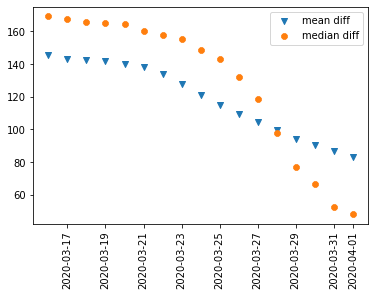

In [16]:
# Function to iterate 16 days from provided start date and plot average price differences between the groups
def find_cutoff(df,start):
    #Create new df to record average price differences between the 2 groups at given day threshold
    dft = pd.DataFrame(index=range(0,17),columns=['day','mean_diff','median_diff'])
    dft.day[0] = pd.to_datetime(start)
    from datetime import timedelta
    for x in range(1,17):  #fill in day values from provided start date
        dft.day[x] = dft.day[x-1] + timedelta(days=1)
    dft.day = pd.to_datetime(dft.day)

    # Optimal day threshold would be where the differences peak
    x = 0 #counter
    for day in dft.day:
        dft.mean_diff[x] = (df[df.Date >= day].Price.mean() - df[df.Date < day].Price.mean())
        dft.median_diff[x] = (df[df.Date >= day].Price.median() - df[df.Date < day].Price.median())
        x+=1
    #Plot differences for visual confirmation
    plt.scatter(dft.day,dft.mean_diff, marker='v', label='mean diff')
    plt.scatter(dft.day,dft.median_diff, marker='8', label='median diff')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show();
    
find_cutoff(df, '2020-03-16')

### That was unexpected! Let's try an earlier start date.
Note that we're looking for the latest date where the 'cliff' starts to drop for both mean and median but it's unlikely that would happen on the same day.

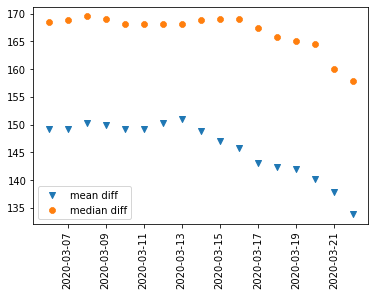

In [17]:
find_cutoff(df, '2020-03-06')

### How's that for a little creepy.. our optimal cutoff day (2020-03-13) was on a Friday the 13th!
Apparently the market on eBay already started experiencing constrained supply and surging demand a few days before the earliest US shutdowns began.
>This makes sense, considering that early panic led to shortages of toilet paper, hand sanitizer and face masks - combined with the anticipation of Animal Crossing's release in a week. The fact that the mean difference started dropping a few days earlier than the median is indicative of small pockets of 'panic bidding' driving up individual listings before the effect spread more broadly across the market.

In [21]:
# View 5 point statistics for the before/after groups
display(df[df.Date<'2020-03-13'].describe(), df[df.Date>='2020-03-13'].describe())

,Price,Shipping,Feedback,FBScore
count,1101.000000,1101.000000,1101.000000,1101.000000
mean,291.100272,9.927366,5231.544959,99.184105
std,84.899934,10.965550,32528.868246,3.724412
min,29.900000,0.000000,-1.000000,33.300000
25%,244.950000,0.000000,25.000000,100.000000
50%,274.990000,7.900000,147.000000,100.000000
75%,311.700000,20.000000,776.000000,100.000000
max,960.000000,54.500000,655440.000000,100.000000


,Price,Shipping,Feedback,FBScore
count,12825.000000,12825.000000,12825.000000,12825.000000
mean,442.048062,10.302119,1743.790253,99.212600
std,71.242563,11.622384,17339.279389,3.308699
min,4.990000,0.000000,-1.000000,50.000000
25%,420.000000,0.000000,18.000000,100.000000
50%,443.150000,8.000000,85.000000,100.000000
75%,463.150000,20.310000,328.000000,100.000000
max,1464.890000,121.450000,625386.000000,100.000000


### Homogenizing our dataset - separate listings into proper groups for analysis
- `Normal`: average new(ish) single system with a few add-ons such as games, accessories (our main focus)
- `Premium`: high outliers - likely bundles with significant add-ons (games, accessories, limited/special editions)
- `Low/Parts`: low outliers - parts/games, accessories, incomplete, damaged systems
- `Switch Lite`: (retail $199.99) already done, but some verification needed

#### Note that in this section there was a lot of manual verification performed by examining outputs of several hundred rows and navigating to specific listing pages.

In [34]:
df[df.Price<200].sort_values('Price')

,Date,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore
4009,2020-04-28 08:08:00,200 Nook Miles Tickets ï¼„4.99USD!!!Animal Crossing Check Description,4.99,0.00,Brand New,https://www.ebay.com/itm/200-Nook-Miles-Tickets-4-99USD-Animal-Crossing-Check-Description/264712...,"['North York', 'Ontario', 'Canada']",virtualwalnut,55.0,100.0
11598,2020-03-27 09:50:00,VoltEdge Nintendo Switch Handheld Controller,10.00,5.00,Brand New,https://www.ebay.com/itm/VoltEdge-Nintendo-Switch-Handheld-Controller/303519736811?hash=item46ab...,"['Murrysville', 'Pennsylvania', 'United States']",eadr40,6.0,100.0
4074,2020-04-27 19:11:00,* BOX ONLY * Nintendo Switch Animal Crossing New Horizon Special Edition BOX,19.99,0.00,Open Box,https://www.ebay.com/itm/BOX-ONLY-Nintendo-Switch-Animal-Crossing-New-Horizon-Special-Edition-BO...,"['Dallas', 'Texas', 'United States']",red_foreman79,404.0,100.0
5932,2020-04-19 15:00:00,nintendo switch games,28.89,0.00,Pre-Owned,https://www.ebay.com/itm/nintendo-switch-games/333573486533?hash=item4daa8777c5:g:pdMAAOSwZWpek4b5,"['Indianapolis', 'Indiana', 'United States']",randspark,16.0,100.0
13383,2020-03-03 05:43:00,Nintendo Switch Mario Kart 8 Deluxe System BOX/INSERTS ONLY NO CONSOLE,29.90,14.90,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-Mario-Kart-8-Deluxe-System-BOX-INSERTS-ONLY-NO-CONSOLE/...,"['Front Royal', 'Virginia', 'United States']",amendment02,238.0,100.0
4944,2020-04-24 06:58:00,* BOX ONLY * Nintendo Switch Animal Crossing New Horizon Special Edition BOX,29.95,0.00,Brand New,https://www.ebay.com/itm/BOX-ONLY-Nintendo-Switch-Animal-Crossing-New-Horizon-Special-Edition-BO...,"['California', 'STATE', 'United States']",veritech1,1467.0,99.2
983,2020-05-09 14:26:00,* BOX ONLY * Nintendo Switch Animal Crossing New Horizon Edition EMPTY BOX,29.99,0.00,Brand New,https://www.ebay.com/itm/BOX-ONLY-Nintendo-Switch-Animal-Crossing-New-Horizon-Edition-EMPTY-BOX/...,"['Easton', 'Pennsylvania', 'United States']",thedorkstork,1324.0,99.9
2209,2020-05-05 00:54:00,* BOX ONLY * Nintendo Switch Animal Crossing New Horizon Edition EMPTY BOX,29.99,0.00,Brand New,https://www.ebay.com/itm/BOX-ONLY-Nintendo-Switch-Animal-Crossing-New-Horizon-Edition-EMPTY-BOX/...,"['Easton', 'Pennsylvania', 'United States']",thedorkstork,1314.0,99.9
10674,2020-03-31 19:17:00,"Nintendo DSi Black Handheld Console System, CLEANED AND TESTED",31.00,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-DSi-Black-Handheld-Console-System-CLEANED-AND-TESTED-/33356339...,"['Phoenix', 'Arizona', 'United States']",phazongames,1457.0,99.8
406,2020-05-12 08:30:00,* BOX ONLY * Nintendo Switch Animal Crossing New Horizon Edition EMPTY BOX,32.89,14.90,Brand New,https://www.ebay.com/itm/BOX-ONLY-Nintendo-Switch-Animal-Crossing-New-Horizon-Edition-EMPTY-BOX/...,"['Glenshaw', 'Pennsylvania', 'United States']",malkinmania,12001.0,99.0


In [39]:
df[df.Price<800].sort_values('Price', ascending=False).head(300)

,Date,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore
1481,2020-05-07 16:10:00,Nintendo Switch Console Animal Crossing New Horizon BUNDLE,799.99,0.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-Console-Animal-Crossing-New-Horizon-BUNDLE-/27435883715...,"['Chesnee', 'South Carolina', 'United States']",wheelersdiscount,4196.0,99.8
9335,2020-04-06 16:47:00,Animal Crossing New Horizons Nintendo Switch Special Edition Console Game & Case,799.99,0.00,Brand New,https://www.ebay.com/itm/Animal-Crossing-New-Horizons-Nintendo-Switch-Special-Edition-Console-Ga...,"['Saugerties', 'New York', 'United States']",m2b_topia,1880.0,99.8
3701,2020-04-29 09:51:00,Nintendo Switch Console Animal Crossing New Horizon BUNDLE,799.99,0.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-Console-Animal-Crossing-New-Horizon-BUNDLE-/27434952049...,"['Chesnee', 'South Carolina', 'United States']",wheelersdiscount,4196.0,99.8
1972,2020-05-05 19:52:00,Nintendo Switch Console Animal Crossing New Horizon BUNDLE,799.99,0.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-Console-Animal-Crossing-New-Horizon-BUNDLE-/28386908586...,"['Chesnee', 'South Carolina', 'United States']",wheelersdiscount,4196.0,99.8
4292,2020-04-26 19:56:00,Nintendo Switch Console Animal Crossing New Horizon BUNDLE,799.99,0.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-Console-Animal-Crossing-New-Horizon-BUNDLE/274347878025...,"['Chesnee', 'South Carolina', 'United States']",wheelersdiscount,4196.0,99.8
8807,2020-04-08 18:45:00,ðŸ”¥ NEW - Nintendo Switch Animal Crossing New Horizons Console System - SHIPS NOW,792.04,12.04,Brand New,https://www.ebay.com/itm/NEW-Nintendo-Switch-Animal-Crossing-New-Horizons-Console-System-SHIPS-N...,"['Los Angeles', 'California', 'United States']",masontop,431.0,100.0
2951,2020-05-01 21:23:00,Nintendo Switch V2 BUNDLE W GAMES & ACCESSORIES,787.89,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-V2-BUNDLE-W-GAMES-ACCESSORIES/254582727844?hash=item3b4...,"['Camden', 'Ohio', 'United States']",cafercoh,33.0,100.0
4055,2020-04-27 20:56:00,Nintendo Switch Console Bundle (3) PRO Controllers (4) Joycon 9 Games Amibo NFC,781.10,21.10,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-Console-Bundle-3-PRO-Controllers-4-Joycon-9-Games-Amibo...,"['Elkhorn City', 'Kentucky', 'United States']",skynetcomm,808.0,100.0
5724,2020-04-20 16:30:00,Nintendo Switch 32GB Gray Console with Neon Red and Neon Blue Joy-Con,775.00,25.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-32GB-Gray-Console-with-Neon-Red-and-Neon-Blue-Joy-Con-/...,"['Palmdale', 'California', 'United States']",soldiergirl746,70.0,100.0
6928,2020-04-15 20:04:00,Animal Crossing Nintendo Switch Console Special Edition ðŸ”¥ðŸ”¥ðŸ”¥,773.15,23.15,Brand New,https://www.ebay.com/itm/Animal-Crossing-Nintendo-Switch-Console-Special-Edition-/274307848037?_...,"['Forest', 'Virginia', 'United States']",804rtgaines,348.0,100.0


In [44]:
df[df.Price>750].sort_values('Price', ascending=False)

,Date,Title,Price,Shipping,Condition,Link,Location,Seller,Feedback,FBScore
8267,2020-04-10 18:46:00,Animal Crossing New Horizons Edition Nintendo Switch Console Bundle,1464.89,64.90,Brand New,https://www.ebay.com/itm/Animal-Crossing-New-Horizons-Edition-Nintendo-Switch-Console-Bundle/264...,"['Atlanta', 'Georgia', 'United States']",grailclub,364.0,100.0
6240,2020-04-18 10:43:00,Nintendo Switch Animal Crossing New Horizons Edition with Games & Accessories,1188.00,0.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-Animal-Crossing-New-Horizons-Edition-with-Games-Accesso...,"['Rockville Centre', 'New York', 'United States']",soles888,2740.0,99.5
927,2020-05-09 18:23:00,Animal Crossing New Horizons Special Edition Nintendo Switch Bundle Game + Extra,1049.00,0.00,Brand New,https://www.ebay.com/itm/Animal-Crossing-New-Horizons-Special-Edition-Nintendo-Switch-Bundle-Gam...,"['Dover', 'New Hampshire', 'United States']",nickt3311,47.0,97.0
5645,2020-04-21 05:18:00,"Massive Nintendo Switch Bundle w/ 16 Games, 3 Pro Controllers, 128GB SD Card",1029.99,30.00,Open Box,https://www.ebay.com/itm/Massive-Nintendo-Switch-Bundle-w-16-Games-3-Pro-Controllers-128GB-SD-Ca...,"['Norman', 'Oklahoma', 'United States']",fzanix,25.0,100.0
10362,2020-04-02 14:52:00,*Ships 3/26* Nintendo Switch Console V2 Gray Joy-Cons Brand New Sealed 32GB Neon,1010.55,11.55,Brand New,https://www.ebay.com/itm/Ships-3-26-Nintendo-Switch-Console-V2-Gray-Joy-Cons-Brand-New-Sealed-32...,"['San Diego', 'California', 'United States']",mono.buy,208.0,100.0
699,2020-05-10 18:32:00,Nintendo Switch Console Animal Crossing New Horizon BUNDLE BRAND NEW RARE,999.99,0.00,Brand New,https://www.ebay.com/itm/Nintendo-Switch-Console-Animal-Crossing-New-Horizon-BUNDLE-BRAND-NEW-RA...,"['Cherry Hill', 'New Jersey', 'United States']",flipmode024,424.0,99.2
12071,2020-03-24 10:28:00,(New) Nintendo Switch 32GB Gray Console (Neon Red/Neon Blue Joy-Con) & 16 Games,999.99,0.00,Brand New,https://www.ebay.com/itm/New-Nintendo-Switch-32GB-Gray-Console-Neon-Red-Neon-Blue-Joy-Con-16-Gam...,"['Rowlett', 'Texas', 'United States']",arcadeplayer7,182.0,100.0
13124,2020-03-09 17:23:00,Nintendo Switch Modded 256gb Bundle!,960.00,0.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-Modded-256gb-Bundle-/324097539770?_trksid=p2349526.m438...,"['Houston', 'Texas', 'United States']",s_medel,66.0,100.0
7720,2020-04-13 02:43:00,Nintendo Switch Console Bundle (3) PRO Controllers (4) Joycon 9 Games Amibo NFC,941.10,21.10,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-Console-Bundle-3-PRO-Controllers-4-Joycon-9-Games-Amibo...,"['Elkhorn City', 'Kentucky', 'United States']",skynetcomm,808.0,100.0
7794,2020-04-12 17:40:00,Nintendo Switch Console BUNDLE - Lots of EXTRAS - Mint Condition - 13 Games,935.00,15.00,Pre-Owned,https://www.ebay.com/itm/Nintendo-Switch-Console-BUNDLE-Lots-of-EXTRAS-Mint-Condition-13-Games/1...,"['Webster', 'Massachusetts', 'United States']",nikesterinc,357.0,100.0


#### Our 'normal' Switch sales will be defined with a range of $100-750 total price, including shipping.

In [48]:
df_mid = df[df.Price>=99.99][df.Price<=750]
df_mid.shape  #confirm how many rows remain

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(13856, 10)

In [47]:
df_high = df[df.Price>750]
df_high.shape  #confirm how many high outliers dropped

(44, 10)

In [49]:
df_low = df[df.Price<99.99]
df_low.shape  #confirm how many low outliers dropped

(26, 10)

#### Not too many outliers dropped.. let's view the price over time plot again now that its scale is more appropriate.

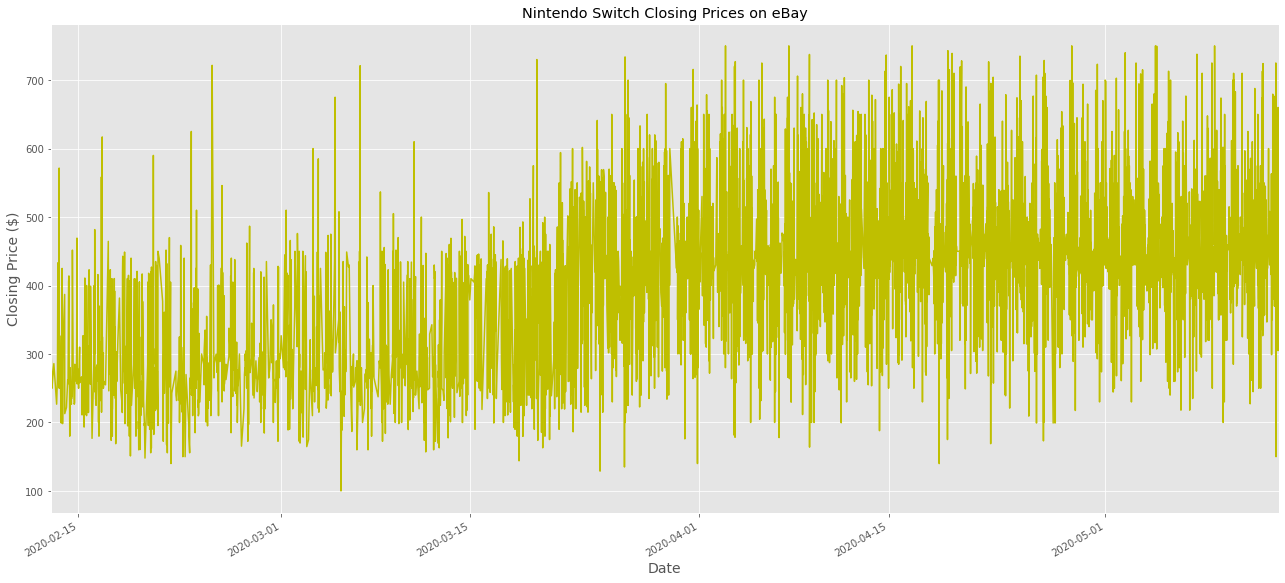

In [157]:
plt.style.use('ggplot')
ax = df_mid.set_index('Date').Price.plot(figsize=(22,10), title='Nintendo Switch Closing Prices on eBay', color='y')
ax.set_ylabel('Closing Price ($)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
plt.show();

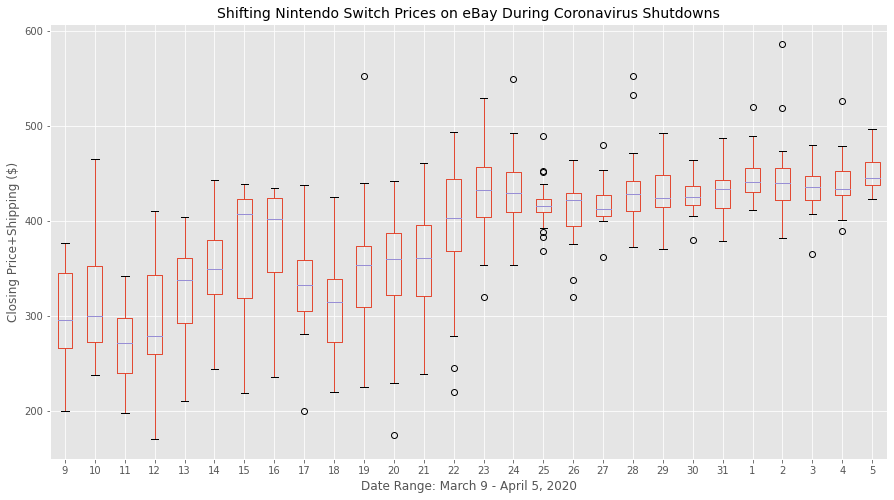

In [166]:
# Zooming in on the transitional weeks
# Use pandas Grouper to group values by mean resampled into hours using daily frequency 
box = df_mid.sort_values('Date').set_index('Date')['2020-03-09':'2020-04-05'].Price.resample('H').mean().groupby(pd.Grouper(freq ='D'))

day_plot = pd.DataFrame()  #new dataframe to store grouped values in columns to plot
for d, group in box:
    day_plot[d.day] = group.values.ravel()

# Generate a box and whiskers plot
day_plot.boxplot(figsize = (15,8));
plt.title('Shifting Nintendo Switch Prices on eBay During Coronavirus Shutdowns', fontsize=14)
plt.ylabel('Closing Price+Shipping ($)')
plt.xlabel('Date Range: March 9 - April 5, 2020')
plt.show;

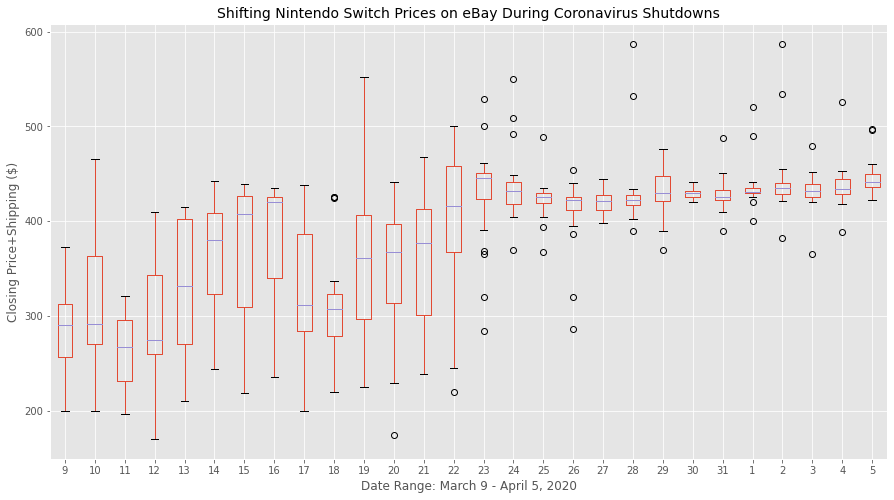

In [165]:
# Same plot as above except using resampled hourly median instead of mean
box = df_mid.sort_values('Date').set_index('Date')['2020-03-09':'2020-04-05'].Price.resample('H').median().groupby(pd.Grouper(freq ='D'))
day_plot = pd.DataFrame()
for d, group in box:
    day_plot[d.day] = group.values.ravel()
day_plot.boxplot(figsize = (15,8));
plt.title('Shifting Nintendo Switch Prices on eBay During Coronavirus Shutdowns', fontsize=14)
plt.ylabel('Closing Price+Shipping ($)')
plt.xlabel('Date Range: March 9 - April 5, 2020')
plt.show;

### Interesting! The hourly median box and whiskers plot really demonstrates visually how much the range of closing prices narrowed starting on Monday March 23, exactly 1 week after the first US state shutdown began in CA.
>In fact, I would be more inclined to identify this as the more optimal cutoff date. However, it's also quite clear that in the 2 weeks prior, the market was already experiencing volatility resulting in overall higher prices.

## Question 1: How large (or small) is the pool of sellers?
    a. How diverse is the pool? Are some 'power sellers' dominating the market?  
    b. Are the 'power sellers' consistently selling for higher closing prices?

In [174]:
# We will define 'power sellers' as having sold at least 5 Switches in our 3 month timeframe
p_sellers = df.Seller.value_counts()[df.Seller.value_counts()>=5]
r_sellers = df.Seller.value_counts()[df.Seller.value_counts()<5]

#Print total listings, # of regular sellers, # of power sellers, % of power sellers, # sold by power sellers, # sold by regular
#sellers, # of sellers that sold exactly 1 (prior owners no longer interested)
print(df.shape,len(r_sellers),len(p_sellers), len(p_sellers)/(len(p_sellers)+len(r_sellers)),p_sellers.sum(),r_sellers.sum(),
      df.Seller.value_counts()[df.Seller.value_counts()==1].sum())
p_sellers.head(10)  #view top power sellers and how many units they sold

(13926, 10) 7448 399 0.05084745762711865 3499 10427 5464


 twobrothersgames       87
 pickingout             87
 wendell13172           54
 4shoresoles            51
 rcherry2121            36
 andshe_9687            34
 moviestarplanet2015    32
 wils1628               30
 d.zellers              29
 goldstar_tech          29
Name: Seller, dtype: int64

In [189]:
# Get 5 point statistics for our REGULAR seller listings showing before/after prices using both cutoff dates
df_reg = df[df.Seller.map(lambda s: True if s in r_sellers.index else False)]
display(df_reg[df_reg.Date<'2020-03-13'].describe(), df_reg[df_reg.Date>='2020-03-13'].describe())
display(df_reg[df_reg.Date<'2020-03-23'].describe(), df_reg[df_reg.Date>='2020-03-23'].describe())

,Price,Shipping,Feedback,FBScore
count,920.000000,920.000000,920.000000,920.000000
mean,292.881391,10.227511,2522.570652,99.182391
std,85.547098,10.930551,23493.206795,3.924701
min,29.900000,0.000000,-1.000000,33.300000
25%,245.612500,0.000000,18.000000,100.000000
50%,275.000000,9.200000,105.500000,100.000000
75%,314.502500,20.017500,525.500000,100.000000
max,960.000000,51.250000,655440.000000,100.000000


,Price,Shipping,Feedback,FBScore
count,9507.000000,9507.000000,9507.000000,9507.000000
mean,441.180535,11.067452,844.354791,99.182308
std,75.740651,11.799058,12541.904341,3.607290
min,4.990000,0.000000,-1.000000,50.000000
25%,419.990000,0.000000,12.000000,100.000000
50%,442.150000,10.000000,60.000000,100.000000
75%,463.995000,22.065000,240.500000,100.000000
max,1464.890000,121.450000,625386.000000,100.000000


,Price,Shipping,Feedback,FBScore
count,1532.000000,1532.000000,1532.000000,1532.000000
mean,319.718022,10.970855,1927.364883,99.214883
std,94.094416,11.268070,18586.757919,3.710463
min,29.900000,0.000000,-1.000000,33.300000
25%,255.000000,0.000000,16.000000,100.000000
50%,291.030000,10.000000,97.000000,100.000000
75%,398.362500,21.572500,454.750000,100.000000
max,960.000000,62.550000,655440.000000,100.000000


,Price,Shipping,Feedback,FBScore
count,8895.000000,8895.000000,8895.000000,8895.000000
mean,446.761801,10.997215,831.402248,99.176706
std,71.176076,11.804780,12875.325373,3.623451
min,4.990000,0.000000,-1.000000,50.000000
25%,422.150000,0.000000,12.000000,100.000000
50%,444.990000,10.000000,59.000000,100.000000
75%,465.000000,22.000000,235.000000,100.000000
max,1464.890000,121.450000,625386.000000,100.000000


In [190]:
# Get 5 point statistics for our POWER seller listings showing before/after prices using both cutoff dates
df_power = df[df.Seller.map(lambda s: True if s in p_sellers.index else False)]
display(df_power[df_power.Date<'2020-03-13'].describe(), df_power[df_power.Date>='2020-03-13'].describe())
display(df_power[df_power.Date<'2020-03-23'].describe(), df_power[df_power.Date>='2020-03-23'].describe())

,Price,Shipping,Feedback,FBScore
count,181.000000,181.000000,181.000000,181.000000
mean,282.047072,8.401768,19000.917127,99.192818
std,81.155615,11.046404,58483.015529,2.475144
min,82.190000,0.000000,12.000000,84.600000
25%,239.950000,0.000000,137.000000,99.700000
50%,266.950000,0.000000,809.000000,100.000000
75%,299.990000,19.990000,6162.000000,100.000000
max,469.250000,54.500000,446407.000000,100.000000


,Price,Shipping,Feedback,FBScore
count,3318.000000,3318.000000,3318.000000,3318.000000
mean,444.533767,8.109225,4320.924955,99.299397
std,56.337930,10.806147,26506.623093,2.241093
min,29.950000,0.000000,0.000000,66.700000
25%,426.107500,0.000000,52.000000,99.700000
50%,444.990000,0.000000,224.000000,100.000000
75%,461.700000,17.860000,717.500000,100.000000
max,1188.000000,59.950000,446230.000000,100.000000


,Price,Shipping,Feedback,FBScore
count,318.000000,318.000000,318.000000,318.000000
mean,318.830031,8.024214,15350.830189,99.253145
std,98.378321,10.756481,54150.464556,2.182907
min,82.190000,0.000000,11.000000,84.600000
25%,249.000000,0.000000,136.000000,99.400000
50%,289.980000,0.000000,751.000000,100.000000
75%,418.997500,18.915000,3289.750000,100.000000
max,541.440000,54.500000,446407.000000,100.000000


,Price,Shipping,Feedback,FBScore
count,3181.000000,3181.000000,3181.000000,3181.000000
mean,447.854640,8.134370,4053.577806,99.297957
std,51.286437,10.824984,25183.200766,2.260767
min,29.950000,0.000000,0.000000,66.700000
25%,429.000000,0.000000,50.000000,99.700000
50%,445.000000,0.000000,221.000000,100.000000
75%,462.980000,17.860000,651.000000,100.000000
max,1188.000000,59.950000,446230.000000,100.000000


#### Nothing too earth shattering - our power sellers make up only 5% of the pool but are responsible for ~25% of sales. Roughly two thirds of all sellers showed up on eBay once to sell their used Switch (likely breaking even or profiting slightly). As expected, both groups sold a substantially higher quantity of items before vs after SIP (5-10x increase monthly).
The average closing prices for our power sellers don't differ much from everyone else. We would conclude that the overall 'net effect' of huge demand over limited supply benefitted everyone who had a Switch to sell. At the same time, buyers pining for one became less discerning over price and prior usage.

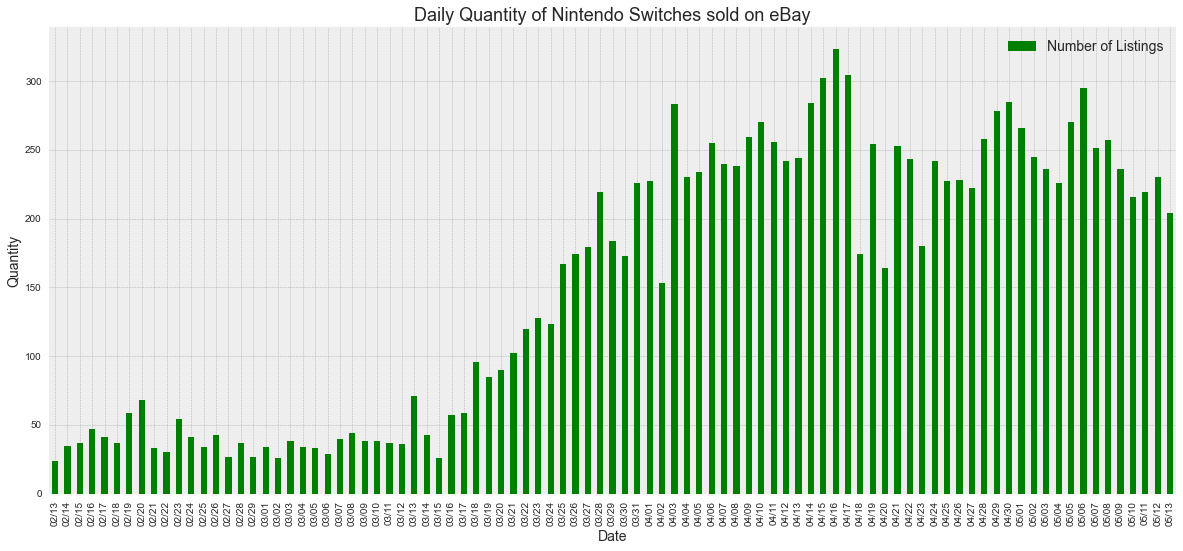

In [366]:
# Plot quantity of listings over time
df_count = pd.DataFrame(range(0,91), columns=['Date'])
df_count.Date[0] = pd.to_datetime('2020-02-13')
for i in df_count.index:
    if i!=0: df_count.Date[i] = df_count.Date[i-1] + pd.to_timedelta(1, unit='days')
df_count.Date = pd.to_datetime(df_count.Date)
df_count.set_index('Date', inplace=True)
df_count['Count'] = 0
for day in df_count.index:
    c = 0
    for row in df.Date:
        if day.date() == row.date(): c+=1
    df_count.Count.loc[day] = c
df_count.index = df_count.index.strftime('%m/%d')

plt.style.use('bmh')
df_count.plot(figsize = (18,8), kind='bar', color='g');
plt.title('Daily Quantity of Nintendo Switches sold on eBay', fontsize=18)
plt.ylabel('Quantity',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.legend(['Number of Listings'], fontsize=14)
plt.show;

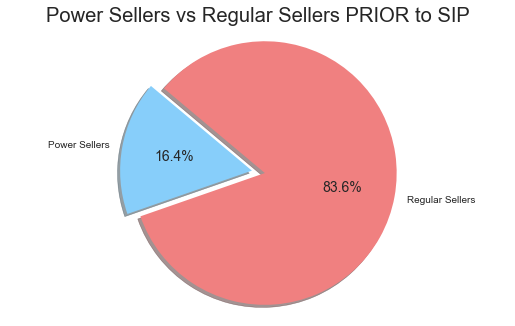

In [428]:
# Before 3/13 cutoff # of listings - r_sellers(920), p_sellers(181) - 1101 total
# Creating pie chart
labels = 'Power Sellers', 'Regular Sellers'
sizes = [16.44, 83.56]
colors = [ 'lightskyblue','lightcoral']
explode = (0.1, 0)  # explode non-severe slice

plt.figure(figsize=(8,5))
plt.title('Power Sellers vs Regular Sellers PRIOR to SIP')
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

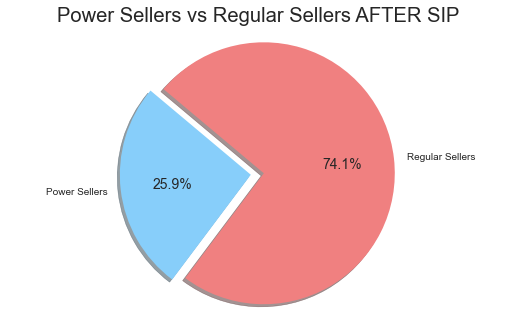

In [429]:
# After 3/13 cutoff # of listings - r_sellers(9507), p_sellers(3318) - 12825 total
# Creating pie chart
labels = 'Power Sellers', 'Regular Sellers'
sizes = [25.87, 74.13]
colors = [ 'lightskyblue','lightcoral']
explode = (0.1, 0)  # explode non-severe slice

plt.figure(figsize=(8,5))
plt.title('Power Sellers vs Regular Sellers AFTER SIP')
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

### Question 2: How has the geography of sellers changed since SIP began?

In [196]:
# Create new columns for each location field
df['City'] = df.Location.str[0]
df['State'] = df.Location.str[1]
df['Country'] = df.Location.str[2]

In [195]:
# Fix location values incorrectly stored as string instead of list
notlist = []
i = 0
for x in df.Location:
    if not isinstance(x, list): notlist.append(i)
    i+=1

for i in notlist:
    df.Location.iloc[i] = [df.Location.iloc[i][1:-1].split(',')[0][1:-1],df.Location.iloc[i][1:-1].split(',')[1][2:-1],
                               df.Location.iloc[i][1:-1].split(',')[2][2:-1]]

In [216]:
# Quantity of Switches sold from each state before, after SIP
states = df[df.Date<'2020-03-13'].State.value_counts()
display(states.head(5))
states = df[df.Date>='2020-03-13'].State.value_counts()
states.head(5)

California      136
New York        113
Florida          77
New Jersey       67
Pennsylvania     63
Name: State, dtype: int64

California    1908
New York      1244
Florida        963
Texas          767
New Jersey     720
Name: State, dtype: int64

In [217]:
# Show count of Switches sold coming from outside the US or Canada before, after SIP
overseas = ['United States','Canada']
display(df[df.Date<'2020-03-13'][df.Country.map(lambda x: False if x in overseas else True)].shape,
        df[df.Date>='2020-03-13'][df.Country.map(lambda x: False if x in overseas else True)].shape)

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(11, 13)

(42, 13)

#### Similar to what we observed above.. ~5x increase in monthly numbers sold from the same big states and almost ~2-3x increase from overseas.

### Question 3: Does the condition of the Switch (brand new vs not) matter as much during a shortage?

In [407]:
display(df_mid[df_mid.Condition=='Brand New'][df_mid.Date<'2020-03-13'].Price.describe(),
        df_mid[df_mid.Condition=='Brand New'][df_mid.Date>='2020-03-13'].Price.describe(),
        df_mid[df_mid.Condition!='Brand New'][df_mid.Date<'2020-03-23'].Price.describe(),
        df_mid[df_mid.Condition!='Brand New'][df_mid.Date>='2020-03-23'].Price.describe())

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


count    348.000000
mean     330.551523
std       75.416614
min      150.000000
25%      279.972500
50%      296.025000
75%      410.000000
max      674.990000
Name: Price, dtype: float64

count    8378.000000
mean      454.304255
std        49.140837
min       128.950000
25%       432.512500
50%       449.950000
75%       465.000000
max       750.000000
Name: Price, dtype: float64

count    1105.000000
mean      286.979032
std        81.121755
min        99.990000
25%       239.990000
50%       266.700000
75%       319.960000
max       730.000000
Name: Price, dtype: float64

count    4025.000000
mean      425.309876
std        75.158780
min       139.900000
25%       393.990000
50%       424.150000
75%       455.000000
max       750.000000
Name: Price, dtype: float64

#### Nothing significantly notable when comparing the brand new group vs everything else using either SIP threshold date. The average price difference of $30-40 stays fairly consistent.

In [409]:
# Get listings sold by sellers that only sold a single unit
i = 0
onetimers = list(df_mid.Seller.value_counts()[df_mid.Seller.value_counts()==1].index)
onetime = []
for seller in df_mid.Seller:
    if seller in onetimers: onetime.append(i)
    i+=1
# Show before/after stats for the one time sellers selling Pre-Owned (unloading unit no longer interested in)
display(df_mid.iloc[onetime][df_mid.iloc[onetime].Date<'2020-03-13'][df_mid.iloc[onetime].Condition=='Pre-Owned'].describe(),
        df_mid.iloc[onetime][df_mid.iloc[onetime].Date>='2020-03-13'][df_mid.iloc[onetime].Condition=='Pre-Owned'].describe())

C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Johnny\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Price,Shipping,Feedback,FBScore
count,305.000000,305.000000,305.000000,305.000000
mean,279.673410,12.167180,1275.445902,99.099672
std,71.158208,11.111665,9852.472752,5.058067
min,149.990000,0.000000,0.000000,33.300000
25%,238.000000,0.000000,15.000000,100.000000
50%,262.700000,12.000000,80.000000,100.000000
75%,301.700000,23.150000,403.000000,100.000000
max,721.000000,47.750000,169490.000000,100.000000


,Price,Shipping,Feedback,FBScore
count,1916.000000,1916.000000,1916.000000,1916.000000
mean,421.060955,14.093878,389.975992,99.441232
std,91.188765,11.342679,1477.308107,3.639376
min,139.900000,0.000000,-1.000000,50.000000
25%,375.000000,0.000000,6.000000,100.000000
50%,423.150000,14.990000,52.000000,100.000000
75%,467.000000,23.150000,234.000000,100.000000
max,750.000000,64.900000,29932.000000,100.000000


#### When isolating the worst condition group (Pre-Owned), we see barely any depreciation at all.
>In fact, before SIP we can see used Nintendo Switch resale pricing was already extremely strong (mean, median holding at 80-90% value of retail cost). After SIP we can observe the standard $130-150 boost uplifting the entire market.

## Modeling - Feature Engineering
After evaluating various methods of prediction modeling, since we were mostly working with the title text - I felt it was most appropriate to just perform a simplified version of NLP that looks for key words that I noticed commonly appeared in higher priced listings. Standard NLP techniques would be more appropriate if we had the entire listing body description scraped as well as the title because then context and frequency of key words could be analyzed.

In [425]:
# Creating simple feature columns looking for a single instance of a key word
# SD - includes additional SD card for additional storage
# AC - includes the game Animal Crossing
# game - includes additional game(s)
# case - includes protective case
# con - includes additional controllers
# Sp - identified as a special/limited edition or bundle
# SIP - before (0) or after (1) March 13

df_model = df_mid.loc[:,['Date','Title','Price','Condition']].reset_index(drop=True)
df_model['SD'],df_model['AC'],df_model['game'],df_model['case'],df_model['con'],df_model['Sp'],df_model['SIP'] = 0,0,0,0,0,0,0
i = 0  #index counter
for title in df_model.Title:
    if 'sd' in title.lower() and 'gb' in title.lower() and ('64' in title.lower() or '128' in title.lower() or 
                                                           '256' in title.lower() or '400' in title.lower()):
        df_model.SD.iloc[i] = 1
    if 'animal' in title.lower(): df_model.AC.iloc[i] = 1
    if 'game' in title.lower(): df_model.game.iloc[i] = 1
    if 'case' in title.lower(): df_model.case.iloc[i] = 1
    if 'control' in title.lower(): df_model.con.iloc[i] = 1
    if 'special' in title.lower() or 'edition' in title.lower() or 'bundle' in title.lower(): df_model.Sp.iloc[i] = 1
    if df_model.Date.iloc[i] >= pd.to_datetime('2020-03-13'): df_model.SIP.iloc[i] = 1
    i+=1

df_model = df_model.drop(columns='Title').set_index('Date')

## Building Linear Regression Model using Ordinary Least Squares

In [427]:
from statsmodels.formula.api import ols

outcome = 'Price'
x_cols = ['Condition','SD','AC','game','case','con','Sp','SIP']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_model).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     1124.
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        12:28:14   Log-Likelihood:                -75520.
No. Observations:               13856   AIC:                         1.511e+05
Df Residuals:                   13844   BIC:                         1.512e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  302.5502      1.880    160.973      0.000     298.866     306.234
Condition[T.New (Other)]   -16.2375      4.662     -3.483      0.000     -25.375      -7.100
Condition[T.Open Box]      -42.8297      2.561    -16.725      0.000     -47.849     -37.810
Condition[T.Pre-Owned]     -50.7030      1.203    -42.158      0.000     -53.060     -48.346
Condition[T.Refurbished]   -45.2282      2.397    -18.868      0.000     -49.927     -40.530
SD                          29.6140      4.490      6.595      0.000      20.812      38.416
AC                          28.1952      2.186     12.900      0.000      23.911      32.479
game                        40.6743      1.806     22.522      0.000      37.134      44.214
case                         7.4396      2.598      2.863      0.004       2.346      12.533
con                         31.7090      2.789     11.371      0.000      26.243      37.175
Sp                          57.4323      1.843     31.165      0.000      53.820      61.045
SIP                        141.9908      1.827     77.735      0.000     138.410     145.571
==============================================================================
Omnibus:                     1685.241   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17128.203
Skew:                          -0.164   Prob(JB):                         0.00
Kurtosis:                       8.437   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Although our prediction model's R2 value (confidence level) could be better, we have quite good Skew, Kurtosis and Cond. No (multicollinearity) scores indicative of good normality which is arguably more important for linear regression. The high F-statistic (1124) is consistent with the lower R2 score indicating higher price prediction variance but Prob (F-statistic) of 0.00 implies varying predictions would be extremely consistent.

When reviewing the list of features and their coefficients, it is quite interesting to note the consistent parallels with real dollar amounts correlating quite well with their actual cost.

- `Intercept`	**302.55** - This is our standard pricing 'floor' which comes in at almost exactly the retail cost of a Switch.
- `Condition[T.New (Other)]`	**-16.23** - The 4 'penalties' for not being brand.. this one clocks in quite close
- `Condition[T.Open Box]`	**-42.82** - This and 'Refurbished' appear to be valued the same by buyers
- `Condition[T.Pre-Owned]`	**-50.70** - Pre-Owned is the closest to 'used' with the largest penalty but it's quite surprising that it comes in very close to the ones above and below it
- `Condition[T.Refurbished]`	**-45.22**
- `SD`	**29.61** - the average 64-256GB SD card, depending on brand, retail for \$20-75
- `AC`	**28.19** - Animal Crossing retails for \$59.99 but we can see a 'bundling' discount here
- `game`	**40.67** - Most Nintendo Switch games cost \$30-60
- `case`	**7.43** - Cases usually range from \$10-30
- `con`	**31.70** - Extra controllers range from \$20-70
- `Sp`	**57.43** - Additional cost for bundles, special/limited editions often include a flagship \$60 game
- `SIP`	**141.99** - Our 'premium' added after SIP began

<img src="sales.PNG" width="600">

## Conclusions

Nintendo spearheads a minority of companies that have enjoyed a tremendous surge in sales due to the global coronavirus pandemic. It should be no surprise that they aren't shy about publicizing the success of the Switch per the chart above from their [website.](https://www.nintendo.co.jp/ir/en/finance/hard_soft/number.html)
Even still today in mid-May 2020, one can do a cursory search on Google Shopping, Amazon and confirm that either units (sold at retail price) are out of stock or being marked up anywhere from 40-100%.

Some retailers that prioritize their bottom line above all else are getting hammered in their site reviews (but units are in stock!):

<img src="walmart.PNG" width="1200">

## Closing Remarks, Reflection, Further Work

When I had originally chosen this capstone project topic, I had thought that one of the pitfalls would be finding creative ways to add complexity. I envisioned pulling every custom added image and text from every listing (even live ones!) and use the most impressive data scientist tools available: **unsupervised/deep learning techniques, NLP and image classifiers**. I was also adamant about scraping the html data manually so that I could gain a more comprehensive understanding vs using eBay's API and making the data collection portion much quicker.

What I was not prepared for was how much time I needed to set aside for **data collection** alone; then **data cleaning** which also took several magnitudes longer than I had anticipated (if 70-80% is normal, this project for me was **~90-95%**). I encountered unforeseen frustrations with the inconsistencies of eBay's site, which was prone to 'randomly' change the layout of a completed listing page: suddenly replacing the body with a similar (live) item ad, randomly losing a closed listing's page (correlated with how old the page was and exponentially more likely after 3 months), different and mutating layouts for power sellers and stores, inconsistencies with where/if information would be stored. In addition, mistakes made by sellers when describing their items - often filling out information incorrectly in pre-defined fields - or sometimes intentionally, attempting to stand out from the crowd.

Further work would involve using the eBay API to make data collection easier/faster and pull text/images from listings if possible. Building a simple app or website that can dynamically update data from eBay with real time pricing and changes, possibly allowing for buyers to be alerted when the pricing premium spread all over the market starts to abate.